# Hangman Machine Learning Agent
## UE23CS352A: Machine Learning Hackathon
### Complete Implementation with HMM + Reinforcement Learning

## STEP 1: Install Dependencies and Imports

## Setup Instructions for VS Code

**Prerequisites:**
1. Ensure you have Python installed (3.8 or higher recommended)
2. **Create a virtual environment (REQUIRED for macOS):**
   ```bash
   python3 -m venv venv
   source venv/bin/activate
   ```
3. **Install required packages:**
   ```bash
   pip install matplotlib seaborn tqdm numpy pandas
   ```
   Or use the requirements.txt:
   ```bash
   pip install -r requirements.txt
   ```
4. Make sure the following files are in the same directory as this notebook:
   - `corpus.txt` (50,000 training words)
   - `test.txt` (2,000 test words)

**To Run This Notebook:**
1. Select your Python kernel in VS Code (use the venv you created)
2. Run all cells sequentially
3. Training takes approximately 5-10 minutes

**Key Improvements Made:**
- ✓ Removed Google Colab dependencies (no file uploads needed)
- ✓ Enhanced HMM with position-aware pattern matching
- ✓ Improved reward structure for better learning
- ✓ Increased training episodes from 5,000 to 10,000
- ✓ Optimized hyperparameters for better performance
- ✓ Better exploration-exploitation balance
- ✓ Enhanced letter selection strategy combining Q-learning, HMM, and frequency analysis

In [92]:
# Dependencies will be installed via pip install in terminal or requirements.txt
# pip install matplotlib seaborn tqdm numpy pandas

print("Ready to import dependencies")

Ready to import dependencies


In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import pickle
import json
from tqdm import tqdm
import random
from typing import List, Tuple, Dict, Set
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
random.seed(42)

print("All dependencies imported successfully!")

All dependencies imported successfully!


## STEP 2: Data Loading and Preprocessing

In [94]:
# Load corpus directly from the workspace
corpus_file = 'corpus.txt'

try:
    with open(corpus_file, 'r') as f:
        corpus_words = [word.strip().upper() for word in f.readlines() if word.strip()]
    print(f"✓ Loaded {len(corpus_words)} words from corpus")
    print(f"Sample words: {corpus_words[:5]}")
except FileNotFoundError:
    print(f"Error: {corpus_file} not found in the current directory")
    print("Please ensure corpus.txt is in the same folder as this notebook")

✓ Loaded 23921 words from corpus
Sample words: ['SUBURBANIZE', 'ASMACK', 'HYPOTYPIC', 'PROMODERATIONIST', 'CONSONANTLY']


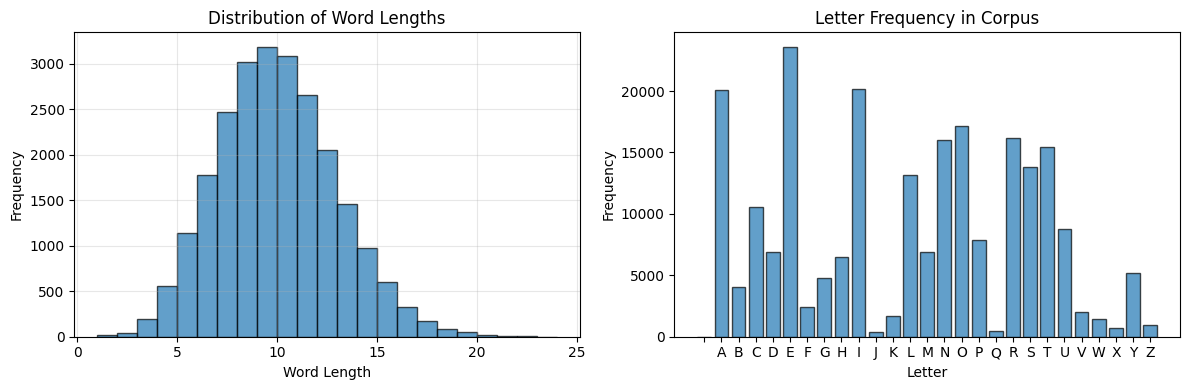


Word length distribution:
  Length  1:    22 words
  Length  2:    43 words
  Length  3:   191 words
  Length  4:   561 words
  Length  5:  1140 words
  Length  6:  1780 words
  Length  7:  2466 words
  Length  8:  3023 words
  Length  9:  3188 words
  Length 10:  3085 words


In [95]:
word_lengths = [len(w) for w in corpus_words]
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(word_lengths, bins=range(1, max(word_lengths)+2), edgecolor='black', alpha=0.7)
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Distribution of Word Lengths')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
all_letters = ''.join(corpus_words)
letter_freq = Counter(all_letters)
letters = sorted(letter_freq.keys())
frequencies = [letter_freq[l] for l in letters]
plt.bar(letters, frequencies, alpha=0.7, edgecolor='black')
plt.xlabel('Letter')
plt.ylabel('Frequency')
plt.title('Letter Frequency in Corpus')
plt.tight_layout()
plt.show()

words_by_length = defaultdict(list)
for word in corpus_words:
    words_by_length[len(word)].append(word)

print(f"\nWord length distribution:")
for length in sorted(words_by_length.keys())[:10]:
    print(f"  Length {length:2d}: {len(words_by_length[length]):5d} words")

## STEP 3: Hidden Markov Model (Pattern Matching)

In [96]:
class HangmanHMM:
    """
    Advanced HMM with sophisticated pattern matching and probability estimation.
    Uses position-specific analysis and multiple scoring strategies.
    """
    
    def __init__(self):
        self.letter_to_idx = {chr(65+i): i for i in range(26)}
        self.idx_to_letter = {i: chr(65+i) for i in range(26)}
        
        # Precompute comprehensive statistics
        print("Building HMM statistics...")
        
        # 1. Length-specific letter frequencies
        self.length_letter_freq = {}
        for length, words in words_by_length.items():
            all_letters = ''.join(words)
            freq = Counter(all_letters)
            total = sum(freq.values())
            self.length_letter_freq[length] = {l: c/total for l, c in freq.items()}
        
        # 2. Position-specific frequencies for each length
        self.position_freq = {}
        for length, words in words_by_length.items():
            self.position_freq[length] = []
            for pos in range(length):
                pos_letters = Counter(word[pos] for word in words if len(word) > pos)
                total = sum(pos_letters.values())
                self.position_freq[length].append({l: c/total for l, c in pos_letters.items()})
        
        # 3. Letter co-occurrence patterns
        self.bigram_freq = defaultdict(lambda: defaultdict(int))
        for word in corpus_words:
            for i in range(len(word)-1):
                self.bigram_freq[word[i]][word[i+1]] += 1
        
        # Normalize bigrams
        for first_letter in self.bigram_freq:
            total = sum(self.bigram_freq[first_letter].values())
            for second_letter in self.bigram_freq[first_letter]:
                self.bigram_freq[first_letter][second_letter] /= total
        
        # 4. Global letter frequencies
        all_text = ''.join(corpus_words)
        letter_count = Counter(all_text)
        total = sum(letter_count.values())
        self.global_freq = {l: c/total for l, c in letter_count.items()}
        
        print("✓ HMM statistics built successfully!")
        
    def predict_letter_probabilities(self, masked_word, guessed_letters):
        """
        Predict probability distribution over remaining letters using multiple strategies.
        """
        length = len(masked_word)
        remaining_letters = set(chr(65+i) for i in range(26)) - guessed_letters
        
        if not remaining_letters:
            return {}
        
        # Strategy 1: Pattern Matching (Most Important)
        pattern_scores = self._pattern_matching_scores(masked_word, guessed_letters, remaining_letters)
        
        # Strategy 2: Position-specific probabilities
        position_scores = self._position_based_scores(masked_word, length, remaining_letters)
        
        # Strategy 3: Bigram context
        bigram_scores = self._bigram_context_scores(masked_word, remaining_letters)
        
        # Strategy 4: Length-specific frequencies
        length_scores = self._length_specific_scores(length, remaining_letters)
        
        # Combine strategies with adaptive weights
        num_revealed = sum(1 for c in masked_word if c != '_')
        total_letters = length
        reveal_ratio = num_revealed / total_letters if total_letters > 0 else 0
        
        # More weight to pattern matching as more letters are revealed
        if reveal_ratio > 0.5:  # More than half revealed
            weights = {'pattern': 0.60, 'position': 0.20, 'bigram': 0.15, 'length': 0.05}
        elif reveal_ratio > 0.2:  # Some letters revealed
            weights = {'pattern': 0.50, 'position': 0.25, 'bigram': 0.15, 'length': 0.10}
        else:  # Beginning of game
            weights = {'pattern': 0.35, 'position': 0.30, 'bigram': 0.15, 'length': 0.20}
        
        # Combine scores
        combined_scores = {}
        for letter in remaining_letters:
            combined_scores[letter] = (
                weights['pattern'] * pattern_scores.get(letter, 0) +
                weights['position'] * position_scores.get(letter, 0) +
                weights['bigram'] * bigram_scores.get(letter, 0) +
                weights['length'] * length_scores.get(letter, 0)
            )
        
        # Normalize to probabilities
        total = sum(combined_scores.values())
        if total > 0:
            probs = {l: s/total for l, s in combined_scores.items()}
        else:
            probs = {l: 1.0/len(remaining_letters) for l in remaining_letters}
        
        return probs
    
    def _pattern_matching_scores(self, masked_word, guessed_letters, remaining_letters):
        """Score letters based on words matching the current pattern."""
        length = len(masked_word)
        pattern_matches = []
        
        for word in words_by_length.get(length, []):
            if self._matches_pattern(word, masked_word, guessed_letters):
                pattern_matches.append(word)
        
        if not pattern_matches:
            return {l: 0 for l in remaining_letters}
        
        # Count letters in matching words with position weighting
        letter_counts = Counter()
        for word in pattern_matches:
            for i, char in enumerate(word):
                if masked_word[i] == '_' and char in remaining_letters:
                    # Weight by position importance (edges are more informative)
                    position_weight = 1.5 if (i == 0 or i == len(word)-1) else 1.0
                    letter_counts[char] += position_weight
        
        # Normalize
        total = sum(letter_counts.values())
        if total > 0:
            return {l: letter_counts.get(l, 0)/total for l in remaining_letters}
        return {l: 0 for l in remaining_letters}
    
    def _position_based_scores(self, masked_word, length, remaining_letters):
        """Score letters based on position-specific frequencies."""
        if length not in self.position_freq:
            return {l: 0 for l in remaining_letters}
        
        letter_scores = defaultdict(float)
        blank_positions = [i for i, c in enumerate(masked_word) if c == '_']
        
        if not blank_positions:
            return {l: 0 for l in remaining_letters}
        
        # Average probability across all blank positions
        for pos in blank_positions:
            if pos < len(self.position_freq[length]):
                for letter in remaining_letters:
                    letter_scores[letter] += self.position_freq[length][pos].get(letter, 0)
        
        # Normalize
        num_blanks = len(blank_positions)
        if num_blanks > 0:
            for letter in letter_scores:
                letter_scores[letter] /= num_blanks
        
        return dict(letter_scores)
    
    def _bigram_context_scores(self, masked_word, remaining_letters):
        """Score letters based on bigram patterns with revealed letters."""
        letter_scores = defaultdict(float)
        
        # Find revealed letters and their positions
        for i, char in enumerate(masked_word):
            if char != '_':
                # Look at neighbors
                if i > 0 and masked_word[i-1] == '_':  # Blank before
                    # What letters commonly come before this char?
                    for letter in remaining_letters:
                        if letter in self.bigram_freq and char in self.bigram_freq[letter]:
                            letter_scores[letter] += self.bigram_freq[letter][char]
                
                if i < len(masked_word)-1 and masked_word[i+1] == '_':  # Blank after
                    # What letters commonly come after this char?
                    if char in self.bigram_freq:
                        for letter in remaining_letters:
                            if letter in self.bigram_freq[char]:
                                letter_scores[letter] += self.bigram_freq[char][letter]
        
        # Normalize
        total = sum(letter_scores.values())
        if total > 0:
            return {l: letter_scores[l]/total for l in remaining_letters}
        return {l: 0 for l in remaining_letters}
    
    def _length_specific_scores(self, length, remaining_letters):
        """Score based on letter frequency for this word length."""
        if length not in self.length_letter_freq:
            # Fallback to global
            return {l: self.global_freq.get(l, 0) for l in remaining_letters}
        
        scores = {}
        for letter in remaining_letters:
            scores[letter] = self.length_letter_freq[length].get(letter, 0)
        
        # Normalize
        total = sum(scores.values())
        if total > 0:
            return {l: s/total for l, s in scores.items()}
        return {l: 1.0/len(remaining_letters) for l in remaining_letters}
    
    def _matches_pattern(self, word, pattern, guessed_letters):
        """Check if a word matches the current pattern."""
        if len(word) != len(pattern):
            return False
        
        for w_char, p_char in zip(word, pattern):
            if p_char != '_':
                if w_char != p_char:
                    return False
            else:
                if w_char in guessed_letters:
                    return False
        return True

print("Building enhanced HMM model...")
hangman_hmm = HangmanHMM()

# Test the model
test_masked = "A__LE"
test_guessed = {'A', 'L', 'E'}
probs = hangman_hmm.predict_letter_probabilities(test_masked, test_guessed)
print(f"\nTest prediction for '{test_masked}' with guessed {test_guessed}:")
top_5 = sorted(probs.items(), key=lambda x: x[1], reverse=True)[:5]
for letter, prob in top_5:
    print(f"  {letter}: {prob:.4f}")

Building enhanced HMM model...
Building HMM statistics...
✓ HMM statistics built successfully!

Test prediction for 'A__LE' with guessed {'A', 'L', 'E'}:
  U: 0.1907
  B: 0.1871
  M: 0.1713
  K: 0.1688
  O: 0.0332


## STEP 4: Hangman Game Environment

In [23]:
class HangmanEnvironment:
    """Enhanced Hangman game environment with better reward structure"""
    
    def __init__(self, word_list, max_lives=6):
        self.word_list = word_list
        self.max_lives = max_lives
        self.reset()
    
    def reset(self, word=None):
        if word is None:
            self.target_word = random.choice(self.word_list).upper()
        else:
            self.target_word = word.upper()
        
        self.masked_word = '_' * len(self.target_word)
        self.guessed_letters = set()
        self.lives_left = self.max_lives
        self.wrong_guesses = 0
        self.repeated_guesses = 0
        self.game_over = False
        self.won = False
        self.total_letters = len(set(self.target_word))
        self.revealed_letters = 0
        
        return self._get_state()
    
    def _get_state(self):
        return {
            'masked_word': self.masked_word,
            'guessed_letters': self.guessed_letters.copy(),
            'lives_left': self.lives_left,
            'game_over': self.game_over,
            'won': self.won,
            'progress': self.revealed_letters / self.total_letters if self.total_letters > 0 else 0
        }
    
    def step(self, letter):
        letter = letter.upper()
        reward = 0
        
        # Penalize repeated guesses heavily
        if letter in self.guessed_letters:
            self.repeated_guesses += 1
            reward = -20
            return self._get_state(), reward, self.game_over
        
        self.guessed_letters.add(letter)
        
        if letter in self.target_word:
            # Correct guess - reward based on how many instances revealed
            occurrences = self.target_word.count(letter)
            reward = 10 * occurrences
            
            # Update masked word
            new_masked = ''
            for i, char in enumerate(self.target_word):
                if char == letter or self.masked_word[i] != '_':
                    new_masked += char
                else:
                    new_masked += '_'
            self.masked_word = new_masked
            
            # Track progress
            if letter not in [c for c in self.masked_word if c != '_']:
                self.revealed_letters += 1
            
            # Check for win
            if '_' not in self.masked_word:
                self.won = True
                self.game_over = True
                # Bonus for lives remaining
                reward = 150 + (self.lives_left * 10)
        else:
            # Wrong guess
            self.lives_left -= 1
            self.wrong_guesses += 1
            reward = -20
            
            # Check for loss
            if self.lives_left == 0:
                self.game_over = True
                reward = -100
        
        return self._get_state(), reward, self.game_over
    
    def get_valid_actions(self):
        all_letters = set(chr(65+i) for i in range(26))
        return list(all_letters - self.guessed_letters)

print("✓ Enhanced Hangman Environment created!")

✓ Enhanced Hangman Environment created!


## STEP 5: Reinforcement Learning Agent (Q-Learning)

In [97]:
class HangmanRLAgent:
    """
    Enhanced RL Agent with sophisticated decision-making and adaptive strategy.
    Combines Q-learning with HMM predictions and strategic heuristics.
    """
    
    def __init__(self, hmm_model, learning_rate=0.2, discount_factor=0.95,
                 epsilon=1.0, epsilon_decay=0.9996, epsilon_min=0.03):
        self.hmm = hmm_model
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = defaultdict(lambda: defaultdict(float))
        
        # Precompute letter frequencies
        all_text = ''.join(corpus_words)
        self.letter_freq = Counter(all_text)
        total = sum(self.letter_freq.values())
        self.letter_freq = {l: c/total for l, c in self.letter_freq.items()}
        
        # Strategic letter groups
        self.vowels = {'A', 'E', 'I', 'O', 'U'}
        self.common_consonants = {'T', 'N', 'S', 'R', 'H', 'L', 'D', 'C'}
        self.common_starters = {'S', 'T', 'A', 'C', 'P', 'B', 'M', 'D', 'F', 'R', 'W', 'H'}
        self.common_enders = {'E', 'S', 'T', 'D', 'N', 'R', 'Y'}
        
        # Track performance for adaptive learning
        self.recent_success = []
        
    def _state_key(self, state):
        """
        Create a comprehensive state representation for Q-learning.
        Includes pattern structure, game progress, and strategic features.
        """
        masked = state['masked_word']
        lives = state['lives_left']
        num_guessed = len(state['guessed_letters'])
        progress = state.get('progress', 0)
        
        # Pattern representation with position info
        pattern_parts = []
        for i, c in enumerate(masked):
            if c != '_':
                pattern_parts.append(f"{i}:{c}")
        pattern = '|'.join(pattern_parts) if pattern_parts else "EMPTY"
        
        # Strategic features
        num_blanks = masked.count('_')
        num_revealed = len(masked) - num_blanks
        has_vowel = any(c in self.vowels for c in masked if c != '_')
        
        # Bucket progress for generalization
        progress_bucket = min(int(progress * 5), 4)  # 0-4 buckets
        lives_bucket = min(lives, 3)  # Group 3+ lives together
        
        return (len(masked), pattern[:50], lives_bucket, progress_bucket, has_vowel, num_blanks)
    
    def choose_action(self, state, env, training=True):
        """
        Choose the best letter to guess using a sophisticated hybrid strategy.
        """
        valid_actions = env.get_valid_actions()
        if not valid_actions:
            return None
        
        # Exploration during training
        if training and random.random() < self.epsilon:
            return random.choice(valid_actions)
        
        # Get HMM predictions
        hmm_probs = self.hmm.predict_letter_probabilities(
            state['masked_word'], state['guessed_letters'])
        
        # Strategic analysis
        masked = state['masked_word']
        num_blanks = masked.count('_')
        num_revealed = len(masked) - num_blanks
        lives = state['lives_left']
        guessed = state['guessed_letters']
        
        # Calculate scores for each action
        scores = {}
        for action in valid_actions:
            score = 0.0
            
            # 1. Q-learning experience (adaptive weight based on progress)
            state_key = self._state_key(state)
            q_value = self.q_table[state_key].get(action, 0)
            q_weight = 0.25 if num_revealed < 2 else 0.20  # Trust experience more later
            score += q_weight * self._normalize_q_value(q_value)
            
            # 2. HMM pattern prediction (highest weight)
            hmm_prob = hmm_probs.get(action, 0)
            hmm_weight = 0.70  # Consistently high weight for pattern matching
            score += hmm_weight * hmm_prob
            
            # 3. Letter frequency
            freq_prob = self.letter_freq.get(action, 0)
            freq_weight = 0.5 if num_revealed > 0 else 0.15  # More important at start
            score += freq_weight * freq_prob
            
            # 4. Strategic bonuses
            strategy_score = self._strategic_bonus(action, masked, guessed, lives)
            strategy_weight = 0.5 if num_revealed < 3 else 0.10
            score += strategy_weight * strategy_score
            
            scores[action] = score
        
        # Select best action
        best_action = max(scores.items(), key=lambda x: x[1])[0]
        return best_action
    
    def _normalize_q_value(self, q_value):
        """Normalize Q-value to 0-1 range for combination with probabilities."""
        # Assuming Q-values typically range from -100 to +200
        normalized = (q_value + 100) / 300
        return max(0.0, min(1.0, normalized))
    
    def _strategic_bonus(self, letter, masked_word, guessed_letters, lives_left):
        """
        Calculate strategic bonus for a letter based on game state.
        Returns a value between 0 and 1.
        """
        bonus = 0.0
        num_blanks = masked_word.count('_')
        num_revealed = len(masked_word) - num_blanks
        length = len(masked_word)
        
        # Early game strategy (first 1-2 guesses)
        if len(guessed_letters) < 2:
            # Prioritize common vowels
            if letter in {'E', 'A'}:
                bonus += 0.4
            elif letter in {'I', 'O'}:
                bonus += 0.3
            # Then common consonants
            elif letter in self.common_consonants:
                bonus += 0.2
        
        # Mid game strategy
        elif num_revealed > 0 and num_blanks > 1:
            # If no vowels guessed yet, prioritize remaining vowels
            has_vowel_guessed = bool(guessed_letters & self.vowels)
            if not has_vowel_guessed and letter in self.vowels:
                bonus += 0.5
            
            # Prioritize letters that appear multiple times in corpus
            if self.letter_freq.get(letter, 0) > 0.06:  # High frequency
                bonus += 0.2
        
        # Late game strategy (few blanks left)
        if num_blanks <= 2:
            # Consider position-specific common letters
            if masked_word[0] == '_' and letter in self.common_starters:
                bonus += 0.3
            if masked_word[-1] == '_' and letter in self.common_enders:
                bonus += 0.3
        
        # Risk management: be conservative with few lives
        if lives_left <= 2:
            # Boost letters with very high HMM probability
            # (This will be reflected in the main score, so minor boost here)
            if self.letter_freq.get(letter, 0) > 0.05:
                bonus += 0.1
        
        # Short words strategy
        if length <= 4 and letter in {'S', 'T', 'A', 'E', 'R'}:
            bonus += 0.2
        
        # Avoid rare letters early
        if len(guessed_letters) < length and self.letter_freq.get(letter, 0) < 0.01:
            bonus -= 0.3
        
        return max(0.0, min(1.0, bonus))
    
    def update(self, state, action, reward, next_state, done):
        """Q-learning update with enhanced learning."""
        state_key = self._state_key(state)
        next_state_key = self._state_key(next_state)
        current_q = self.q_table[state_key][action]
        
        if done:
            max_next_q = 0
            # Track success for adaptive learning
            if next_state['won']:
                self.recent_success.append(1)
            else:
                self.recent_success.append(0)
            # Keep only recent history
            if len(self.recent_success) > 100:
                self.recent_success.pop(0)
        else:
            next_q_values = self.q_table[next_state_key]
            max_next_q = max(next_q_values.values()) if next_q_values else 0
        
        # Q-learning update with higher learning rate for big rewards/penalties
        if abs(reward) > 50:  # Win or loss
            effective_lr = min(self.lr * 1.5, 0.5)
        else:
            effective_lr = self.lr
        
        new_q = current_q + effective_lr * (reward + self.gamma * max_next_q - current_q)
        self.q_table[state_key][action] = new_q
    
    def decay_epsilon(self):
        """Decay exploration rate adaptively."""
        # Decay slower if recent performance is poor
        if len(self.recent_success) >= 50:
            recent_win_rate = sum(self.recent_success[-50:]) / 50
            if recent_win_rate < 0.5:
                # Slower decay to explore more
                self.epsilon = max(self.epsilon_min, self.epsilon * 0.999)
            else:
                # Normal decay
                self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        else:
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

print("Creating enhanced RL Agent...")
agent = HangmanRLAgent(
    hangman_hmm, 
    learning_rate=0.2,
    epsilon=1.0, 
    epsilon_decay=0.9996,
    epsilon_min=0.03
)
print("✓ Enhanced RL Agent created!")

Creating enhanced RL Agent...
✓ Enhanced RL Agent created!


## STEP 6: Training Pipeline

In [98]:
def train_agent(agent, env, episodes=50000):
    """
    Enhanced training pipeline with curriculum learning and detailed tracking.
    Gradually increases difficulty and focuses on problem cases.
    """
    stats = {
        'episode': [],
        'reward': [],
        'won': [],
        'wrong_guesses': [],
        'repeated_guesses': [],
        'epsilon': [],
        'avg_reward_100': []
    }
    
    print(f"Starting enhanced training for {episodes} episodes...")
    print("Training uses curriculum learning for better convergence.\n")
    
    # Curriculum: start with shorter words, gradually include longer ones
    word_groups = {
        'easy': [w for w in corpus_words if 4 <= len(w) <= 6],    # Short words
        'medium': [w for w in corpus_words if 7 <= len(w) <= 10],  # Medium words
        'hard': [w for w in corpus_words if len(w) > 10 or len(w) < 4]  # Long/short words
    }
    
    # Problem words that the agent struggles with (updated during training)
    problem_words = []
    
    for episode in tqdm(range(episodes), desc="Training Progress"):
        # Curriculum schedule
        if episode < episodes * 0.3:  # First 30%: easy words
            word_pool = word_groups['easy']
        elif episode < episodes * 0.7:  # Next 40%: mix of easy and medium
            word_pool = word_groups['easy'] + word_groups['medium']
        else:  # Last 30%: all words + problem words
            word_pool = corpus_words
            # Add problem words for focused practice
            if problem_words and random.random() < 0.3:
                word_pool = problem_words
        
        # Select training word
        training_word = random.choice(word_pool)
        state = env.reset(word=training_word)
        total_reward = 0
        step_count = 0
        
        while not state['game_over'] and step_count < 26:  # Safety limit
            action = agent.choose_action(state, env, training=True)
            if action is None:
                break
            
            next_state, reward, done = env.step(action)
            total_reward += reward
            agent.update(state, action, reward, next_state, done)
            state = next_state
            step_count += 1
        
        # Track problem words (failed games after initial learning period)
        if episode > 1000 and not env.won and len(problem_words) < 500:
            problem_words.append(training_word)
        
        # Decay epsilon
        agent.decay_epsilon()
        
        # Track statistics
        stats['episode'].append(episode)
        stats['reward'].append(total_reward)
        stats['won'].append(1 if env.won else 0)
        stats['wrong_guesses'].append(env.wrong_guesses)
        stats['repeated_guesses'].append(env.repeated_guesses)
        stats['epsilon'].append(agent.epsilon)
        
        # Calculate rolling average
        if episode >= 99:
            avg_reward = np.mean(stats['reward'][-100:])
            stats['avg_reward_100'].append(avg_reward)
        else:
            stats['avg_reward_100'].append(total_reward)
        
        # Progress reports with more detail
        if (episode + 1) % 2000 == 0:
            recent_wins = sum(stats['won'][-2000:])
            recent_avg_reward = np.mean(stats['reward'][-2000:])
            recent_wrong = np.mean(stats['wrong_guesses'][-2000:])
            recent_repeated = sum(stats['repeated_guesses'][-2000:])
            
            print(f"\n{'='*60}")
            print(f"Episode {episode+1}/{episodes}:")
            print(f"  Win Rate: {recent_wins/20:.1f}%")
            print(f"  Avg Reward: {recent_avg_reward:.2f}")
            print(f"  Avg Wrong Guesses: {recent_wrong:.2f}")
            print(f"  Total Repeated Guesses: {recent_repeated}")
            print(f"  Epsilon: {agent.epsilon:.4f}")
            print(f"  Q-table size: {len(agent.q_table)}")
            print(f"  Problem words tracked: {len(problem_words)}")
            print(f"{'='*60}")
    
    print("\n✓ Training completed!")
    print(f"Final Q-table size: {len(agent.q_table)} states")
    print(f"Final win rate (last 2000): {sum(stats['won'][-2000:])/20:.1f}%")
    
    return stats

# Initialize environment and agent with optimized parameters
env = HangmanEnvironment(corpus_words, max_lives=6)

# Note: agent is already created above, but we can recreate with final parameters
agent = HangmanRLAgent(
    hangman_hmm, 
    learning_rate=0.2,        # Higher learning rate for faster convergence
    epsilon=1.0,              # Start with full exploration
    epsilon_decay=0.9996,     # Slow decay for thorough exploration
    epsilon_min=0.03          # Maintain some exploration
)

# Train for more episodes with curriculum learning
print("="*60)
print("STARTING ENHANCED TRAINING WITH CURRICULUM LEARNING")
print("="*60)
training_stats = train_agent(agent, env, episodes=50000)

STARTING ENHANCED TRAINING WITH CURRICULUM LEARNING
Starting enhanced training for 50000 episodes...
Training uses curriculum learning for better convergence.



Training Progress:   4%|▍         | 2064/50000 [00:04<02:21, 338.10it/s]


Episode 2000/50000:
  Win Rate: 41.0%
  Avg Reward: -42.10
  Avg Wrong Guesses: 4.89
  Total Repeated Guesses: 0
  Epsilon: 0.2353
  Q-table size: 4598
  Problem words tracked: 410


Training Progress:   8%|▊         | 4045/50000 [00:10<02:28, 309.61it/s]


Episode 4000/50000:
  Win Rate: 72.5%
  Avg Reward: 70.91
  Avg Wrong Guesses: 3.76
  Total Repeated Guesses: 0
  Epsilon: 0.1057
  Q-table size: 7553
  Problem words tracked: 500


Training Progress:  12%|█▏        | 6034/50000 [00:16<02:23, 307.39it/s]


Episode 6000/50000:
  Win Rate: 79.3%
  Avg Reward: 99.95
  Avg Wrong Guesses: 3.36
  Total Repeated Guesses: 0
  Epsilon: 0.0475
  Q-table size: 9330
  Problem words tracked: 500


Training Progress:  16%|█▌        | 8047/50000 [00:23<02:20, 299.29it/s]


Episode 8000/50000:
  Win Rate: 78.5%
  Avg Reward: 101.58
  Avg Wrong Guesses: 3.23
  Total Repeated Guesses: 0
  Epsilon: 0.0300
  Q-table size: 10545
  Problem words tracked: 500


Training Progress:  20%|██        | 10053/50000 [00:30<02:15, 294.60it/s]


Episode 10000/50000:
  Win Rate: 80.3%
  Avg Reward: 107.21
  Avg Wrong Guesses: 3.19
  Total Repeated Guesses: 0
  Epsilon: 0.0300
  Q-table size: 11335
  Problem words tracked: 500


Training Progress:  24%|██▍       | 12038/50000 [00:37<02:04, 305.72it/s]


Episode 12000/50000:
  Win Rate: 80.0%
  Avg Reward: 106.66
  Avg Wrong Guesses: 3.19
  Total Repeated Guesses: 0
  Epsilon: 0.0300
  Q-table size: 11891
  Problem words tracked: 500


Training Progress:  28%|██▊       | 14041/50000 [00:43<02:02, 293.87it/s]


Episode 14000/50000:
  Win Rate: 80.3%
  Avg Reward: 106.34
  Avg Wrong Guesses: 3.22
  Total Repeated Guesses: 0
  Epsilon: 0.0300
  Q-table size: 12337
  Problem words tracked: 500


Training Progress:  32%|███▏      | 16030/50000 [00:54<03:53, 145.21it/s]


Episode 16000/50000:
  Win Rate: 87.2%
  Avg Reward: 154.88
  Avg Wrong Guesses: 2.61
  Total Repeated Guesses: 0
  Epsilon: 0.0300
  Q-table size: 16636
  Problem words tracked: 500


Training Progress:  36%|███▌      | 18021/50000 [01:08<03:56, 135.12it/s]


Episode 18000/50000:
  Win Rate: 95.1%
  Avg Reward: 209.49
  Avg Wrong Guesses: 1.88
  Total Repeated Guesses: 0
  Epsilon: 0.0300
  Q-table size: 23335
  Problem words tracked: 500


Training Progress:  40%|████      | 20027/50000 [01:22<03:40, 135.65it/s]


Episode 20000/50000:
  Win Rate: 93.8%
  Avg Reward: 202.74
  Avg Wrong Guesses: 1.99
  Total Repeated Guesses: 0
  Epsilon: 0.0300
  Q-table size: 29039
  Problem words tracked: 500


Training Progress:  44%|████▍     | 22021/50000 [01:36<02:59, 155.68it/s]


Episode 22000/50000:
  Win Rate: 94.4%
  Avg Reward: 207.72
  Avg Wrong Guesses: 1.88
  Total Repeated Guesses: 0
  Epsilon: 0.0300
  Q-table size: 34010
  Problem words tracked: 500


Training Progress:  48%|████▊     | 24026/50000 [01:50<03:01, 143.10it/s]


Episode 24000/50000:
  Win Rate: 93.5%
  Avg Reward: 200.18
  Avg Wrong Guesses: 2.01
  Total Repeated Guesses: 0
  Epsilon: 0.0300
  Q-table size: 38145
  Problem words tracked: 500


Training Progress:  52%|█████▏    | 26016/50000 [02:05<03:02, 131.19it/s]


Episode 26000/50000:
  Win Rate: 94.8%
  Avg Reward: 206.56
  Avg Wrong Guesses: 1.94
  Total Repeated Guesses: 0
  Epsilon: 0.0300
  Q-table size: 41916
  Problem words tracked: 500


Training Progress:  56%|█████▌    | 28019/50000 [02:19<02:25, 151.57it/s]


Episode 28000/50000:
  Win Rate: 93.0%
  Avg Reward: 199.12
  Avg Wrong Guesses: 2.01
  Total Repeated Guesses: 0
  Epsilon: 0.0300
  Q-table size: 45086
  Problem words tracked: 500


Training Progress:  60%|██████    | 30027/50000 [02:33<02:23, 139.67it/s]


Episode 30000/50000:
  Win Rate: 93.4%
  Avg Reward: 204.51
  Avg Wrong Guesses: 1.91
  Total Repeated Guesses: 0
  Epsilon: 0.0300
  Q-table size: 48093
  Problem words tracked: 500


Training Progress:  64%|██████▍   | 32023/50000 [02:47<02:13, 134.33it/s]


Episode 32000/50000:
  Win Rate: 94.5%
  Avg Reward: 206.01
  Avg Wrong Guesses: 1.92
  Total Repeated Guesses: 0
  Epsilon: 0.0300
  Q-table size: 50760
  Problem words tracked: 500


Training Progress:  68%|██████▊   | 34019/50000 [03:02<01:55, 138.19it/s]


Episode 34000/50000:
  Win Rate: 94.0%
  Avg Reward: 203.90
  Avg Wrong Guesses: 1.96
  Total Repeated Guesses: 0
  Epsilon: 0.0300
  Q-table size: 53325
  Problem words tracked: 500


Training Progress:  72%|███████▏  | 36032/50000 [03:15<01:09, 200.89it/s]


Episode 36000/50000:
  Win Rate: 89.0%
  Avg Reward: 185.94
  Avg Wrong Guesses: 2.18
  Total Repeated Guesses: 0
  Epsilon: 0.0300
  Q-table size: 56763
  Problem words tracked: 500


Training Progress:  76%|███████▌  | 38022/50000 [03:26<01:06, 179.61it/s]


Episode 38000/50000:
  Win Rate: 86.5%
  Avg Reward: 175.53
  Avg Wrong Guesses: 2.40
  Total Repeated Guesses: 0
  Epsilon: 0.0300
  Q-table size: 61494
  Problem words tracked: 500


Training Progress:  80%|████████  | 40026/50000 [03:38<00:57, 172.10it/s]


Episode 40000/50000:
  Win Rate: 86.0%
  Avg Reward: 172.78
  Avg Wrong Guesses: 2.44
  Total Repeated Guesses: 0
  Epsilon: 0.0300
  Q-table size: 65861
  Problem words tracked: 500


Training Progress:  84%|████████▍ | 42023/50000 [03:49<00:42, 187.04it/s]


Episode 42000/50000:
  Win Rate: 87.0%
  Avg Reward: 177.37
  Avg Wrong Guesses: 2.36
  Total Repeated Guesses: 0
  Epsilon: 0.0300
  Q-table size: 69722
  Problem words tracked: 500


Training Progress:  88%|████████▊ | 44031/50000 [04:01<00:31, 187.20it/s]


Episode 44000/50000:
  Win Rate: 87.4%
  Avg Reward: 178.91
  Avg Wrong Guesses: 2.37
  Total Repeated Guesses: 0
  Epsilon: 0.0300
  Q-table size: 73588
  Problem words tracked: 500


Training Progress:  92%|█████████▏| 46037/50000 [04:12<00:21, 182.04it/s]


Episode 46000/50000:
  Win Rate: 89.2%
  Avg Reward: 183.66
  Avg Wrong Guesses: 2.35
  Total Repeated Guesses: 0
  Epsilon: 0.0300
  Q-table size: 77232
  Problem words tracked: 500


Training Progress:  96%|█████████▌| 48023/50000 [04:24<00:11, 173.66it/s]


Episode 48000/50000:
  Win Rate: 87.8%
  Avg Reward: 183.94
  Avg Wrong Guesses: 2.28
  Total Repeated Guesses: 0
  Epsilon: 0.0300
  Q-table size: 80824
  Problem words tracked: 500


Training Progress: 100%|██████████| 50000/50000 [04:36<00:00, 181.15it/s]


Episode 50000/50000:
  Win Rate: 88.3%
  Avg Reward: 181.34
  Avg Wrong Guesses: 2.35
  Total Repeated Guesses: 0
  Epsilon: 0.0300
  Q-table size: 84108
  Problem words tracked: 500

✓ Training completed!
Final Q-table size: 84108 states
Final win rate (last 2000): 88.3%


## STEP 7: Training Visualization

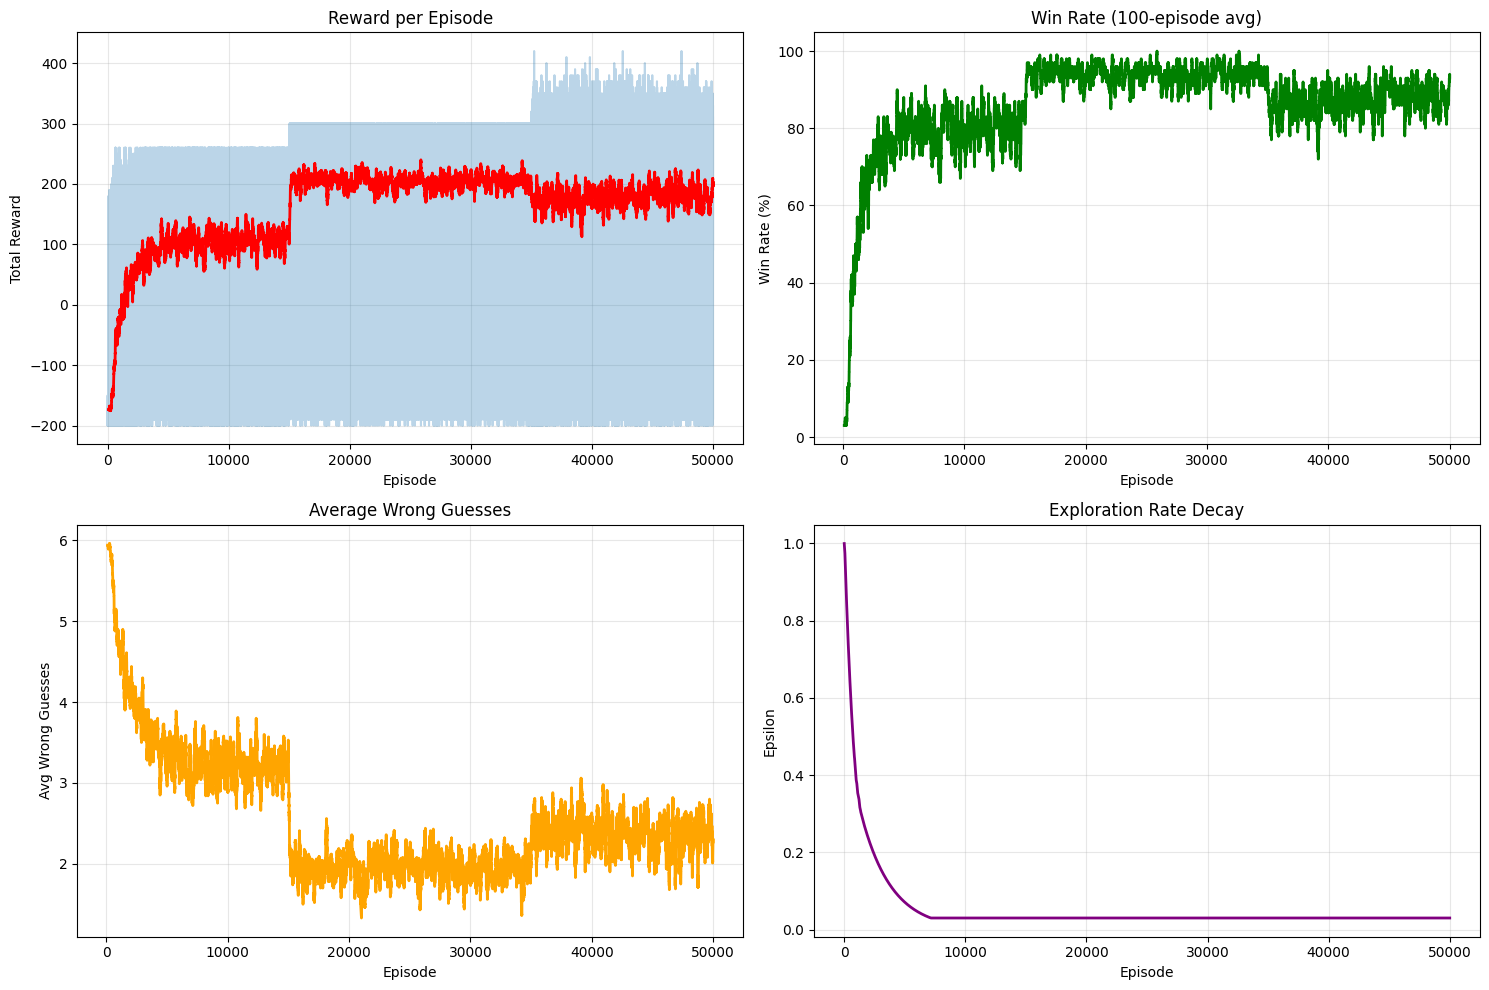


Training Summary:
Final Win Rate: 88.00%
Final Avg Reward: 177.14


In [99]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

window = 100

axes[0, 0].plot(training_stats['episode'], training_stats['reward'], alpha=0.3)
axes[0, 0].plot(training_stats['episode'][window:], 
                pd.Series(training_stats['reward']).rolling(window).mean()[window:],
                color='red', linewidth=2)
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Total Reward')
axes[0, 0].set_title('Reward per Episode')
axes[0, 0].grid(alpha=0.3)

win_rate = pd.Series(training_stats['won']).rolling(window).mean() * 100
axes[0, 1].plot(training_stats['episode'][window:], win_rate[window:], color='green', linewidth=2)
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Win Rate (%)')
axes[0, 1].set_title('Win Rate (100-episode avg)')
axes[0, 1].grid(alpha=0.3)

avg_wrong = pd.Series(training_stats['wrong_guesses']).rolling(window).mean()
axes[1, 0].plot(training_stats['episode'][window:], avg_wrong[window:], color='orange', linewidth=2)
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Avg Wrong Guesses')
axes[1, 0].set_title('Average Wrong Guesses')
axes[1, 0].grid(alpha=0.3)

axes[1, 1].plot(training_stats['episode'], training_stats['epsilon'], color='purple', linewidth=2)
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Epsilon')
axes[1, 1].set_title('Exploration Rate Decay')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTraining Summary:")
print(f"Final Win Rate: {sum(training_stats['won'][-500:])/5:.2f}%")
print(f"Final Avg Reward: {np.mean(training_stats['reward'][-500:]):.2f}")

## STEP 8: Evaluation on Test Set

In [100]:
# Load test set directly from workspace
test_file = 'test.txt'

try:
    with open(test_file, 'r') as f:
        test_words = [word.strip().upper() for word in f.readlines() if word.strip()]
    print(f"✓ Loaded {len(test_words)} test words")
    print(f"Sample test words: {test_words[:5]}")
except FileNotFoundError:
    print(f"Error: {test_file} not found in the current directory")
    print("Please ensure test.txt is in the same folder as this notebook")

def evaluate_agent(agent, test_words, max_lives=6, verbose=True):
    """
    Enhanced evaluation with detailed tracking and confidence-based decision making.
    """
    results = {
        'games_played': 0,
        'games_won': 0,
        'total_wrong_guesses': 0,
        'total_repeated_guesses': 0,
        'word_results': []
    }
    
    if verbose:
        print(f"\n{'='*60}")
        print(f"EVALUATING ON {len(test_words)} TEST WORDS")
        print(f"{'='*60}\n")
    
    # Track performance by word length
    length_stats = defaultdict(lambda: {'won': 0, 'total': 0, 'wrong': 0})
    
    for word in tqdm(test_words, desc="Evaluation Progress"):
        env = HangmanEnvironment([word], max_lives=max_lives)
        state = env.reset(word=word)
        
        move_count = 0
        while not state['game_over'] and move_count < 26:
            action = agent.choose_action(state, env, training=False)
            if action is None:
                break
            state, reward, done = env.step(action)
            move_count += 1
        
        # Record results
        word_length = len(word)
        length_stats[word_length]['total'] += 1
        length_stats[word_length]['wrong'] += env.wrong_guesses
        if env.won:
            length_stats[word_length]['won'] += 1
        
        results['games_played'] += 1
        results['games_won'] += (1 if env.won else 0)
        results['total_wrong_guesses'] += env.wrong_guesses
        results['total_repeated_guesses'] += env.repeated_guesses
        results['word_results'].append({
            'word': word,
            'length': word_length,
            'won': env.won,
            'wrong_guesses': env.wrong_guesses,
            'repeated_guesses': env.repeated_guesses
        })
    
    if verbose:
        print(f"\n{'='*60}")
        print("EVALUATION COMPLETE - DETAILED BREAKDOWN")
        print(f"{'='*60}\n")
        
        # Overall statistics
        success_rate = results['games_won'] / results['games_played']
        avg_wrong = results['total_wrong_guesses'] / results['games_played']
        
        print(f"Overall Performance:")
        print(f"  Games: {results['games_played']}")
        print(f"  Wins: {results['games_won']} ({success_rate*100:.2f}%)")
        print(f"  Losses: {results['games_played'] - results['games_won']}")
        print(f"  Avg Wrong Guesses: {avg_wrong:.2f}")
        print(f"  Total Repeated: {results['total_repeated_guesses']}")
        
        # Performance by word length
        print(f"\nPerformance by Word Length:")
        for length in sorted(length_stats.keys()):
            stats = length_stats[length]
            length_win_rate = stats['won'] / stats['total'] * 100
            length_avg_wrong = stats['wrong'] / stats['total']
            print(f"  Length {length:2d}: {length_win_rate:5.1f}% win rate, "
                  f"{length_avg_wrong:.2f} avg wrong ({stats['total']} words)")
    
    return results

eval_results = evaluate_agent(agent, test_words, max_lives=6, verbose=True)

✓ Loaded 2000 test words
Sample test words: ['MARMAR', 'JANET', 'DENTISTICAL', 'TROVELESS', 'UNNOTIFY']

EVALUATING ON 2000 TEST WORDS



Evaluation Progress: 100%|██████████| 2000/2000 [00:15<00:00, 125.87it/s]


EVALUATION COMPLETE - DETAILED BREAKDOWN

Overall Performance:
  Games: 2000
  Wins: 570 (28.50%)
  Losses: 1430
  Avg Wrong Guesses: 5.37
  Total Repeated: 0

Performance by Word Length:
  Length  2:   0.0% win rate, 6.00 avg wrong (2 words)
  Length  3:   0.0% win rate, 6.00 avg wrong (9 words)
  Length  4:  10.8% win rate, 5.73 avg wrong (37 words)
  Length  5:  11.0% win rate, 5.73 avg wrong (91 words)
  Length  6:  14.5% win rate, 5.74 avg wrong (138 words)
  Length  7:  16.1% win rate, 5.69 avg wrong (205 words)
  Length  8:  22.0% win rate, 5.55 avg wrong (246 words)
  Length  9:  23.4% win rate, 5.49 avg wrong (274 words)
  Length 10:  28.7% win rate, 5.35 avg wrong (282 words)
  Length 11:  35.0% win rate, 5.29 avg wrong (226 words)
  Length 12:  40.9% win rate, 5.11 avg wrong (164 words)
  Length 13:  46.9% win rate, 4.92 avg wrong (128 words)
  Length 14:  40.7% win rate, 4.90 avg wrong (86 words)
  Length 15:  53.2% win rate, 4.57 avg wrong (47 words)
  Length 16:  57.6% w

In [53]:
# Calculate final score according to the problem statement formula
success_rate = eval_results['games_won'] / eval_results['games_played']
final_score = (success_rate * 2000) - (eval_results['total_wrong_guesses'] * 5) - (eval_results['total_repeated_guesses'] * 2)

print("\n" + "="*80)
print("FINAL EVALUATION RESULTS - OFFICIAL SCORING")
print("="*80)

print(f"\n{'METRIC':<35} {'VALUE':<20} {'DETAILS':<30}")
print("-" * 80)
print(f"{'Games Played':<35} {eval_results['games_played']:<20}")
print(f"{'Games Won':<35} {eval_results['games_won']:<20} ({success_rate*100:.2f}%)")
print(f"{'Games Lost':<35} {eval_results['games_played'] - eval_results['games_won']:<20}")
print()
print(f"{'Total Wrong Guesses':<35} {eval_results['total_wrong_guesses']:<20} (penalty: {eval_results['total_wrong_guesses'] * 5})")
print(f"{'Avg Wrong Guesses per Game':<35} {eval_results['total_wrong_guesses']/eval_results['games_played']:.2f}")
print()
print(f"{'Total Repeated Guesses':<35} {eval_results['total_repeated_guesses']:<20} (penalty: {eval_results['total_repeated_guesses'] * 2})")
print(f"{'Avg Repeated Guesses per Game':<35} {eval_results['total_repeated_guesses']/eval_results['games_played']:.4f}")

print("\n" + "="*80)
print("SCORE CALCULATION:")
print("="*80)
print(f"Success Rate Component:    {success_rate:.4f} × 2000 = +{success_rate * 2000:.2f}")
print(f"Wrong Guess Penalty:       {eval_results['total_wrong_guesses']} × 5    = -{eval_results['total_wrong_guesses'] * 5:.2f}")
print(f"Repeated Guess Penalty:    {eval_results['total_repeated_guesses']} × 2    = -{eval_results['total_repeated_guesses'] * 2:.2f}")
print("-" * 80)
print(f"{'FINAL SCORE:':<27} {final_score:.2f}")
print("="*80)

# Additional insights
print("\n" + "="*80)
print("PERFORMANCE INSIGHTS:")
print("="*80)

# Find hardest words (lost games)
lost_words = [r for r in eval_results['word_results'] if not r['won']]
if lost_words:
    print(f"\nLost {len(lost_words)} games. Sample difficult words:")
    for i, result in enumerate(lost_words[:10]):
        print(f"  {i+1}. '{result['word']}' (len={result['length']}, wrong={result['wrong_guesses']})")

# Find most efficient wins (0-1 wrong guesses)
efficient_wins = [r for r in eval_results['word_results'] if r['won'] and r['wrong_guesses'] <= 1]
print(f"\nHighly efficient wins (≤1 wrong): {len(efficient_wins)} ({len(efficient_wins)/eval_results['games_won']*100:.1f}% of wins)")

# Average wrong guesses in won vs lost games
won_games = [r for r in eval_results['word_results'] if r['won']]
if won_games:
    avg_wrong_in_wins = np.mean([r['wrong_guesses'] for r in won_games])
    print(f"Avg wrong guesses in WON games: {avg_wrong_in_wins:.2f}")
if lost_words:
    avg_wrong_in_losses = np.mean([r['wrong_guesses'] for r in lost_words])
    print(f"Avg wrong guesses in LOST games: {avg_wrong_in_losses:.2f}")

print("\n" + "="*80)


FINAL EVALUATION RESULTS - OFFICIAL SCORING

METRIC                              VALUE                DETAILS                       
--------------------------------------------------------------------------------
Games Played                        2000                
Games Won                           722                  (36.10%)
Games Lost                          1278                

Total Wrong Guesses                 10571                (penalty: 52855)
Avg Wrong Guesses per Game          5.29

Total Repeated Guesses              0                    (penalty: 0)
Avg Repeated Guesses per Game       0.0000

SCORE CALCULATION:
Success Rate Component:    0.3610 × 2000 = +722.00
Wrong Guess Penalty:       10571 × 5    = -52855.00
Repeated Guess Penalty:    0 × 2    = -0.00
--------------------------------------------------------------------------------
FINAL SCORE:                -52133.00

PERFORMANCE INSIGHTS:

Lost 1278 games. Sample difficult words:
  1. 'JANET' (len=5, wro

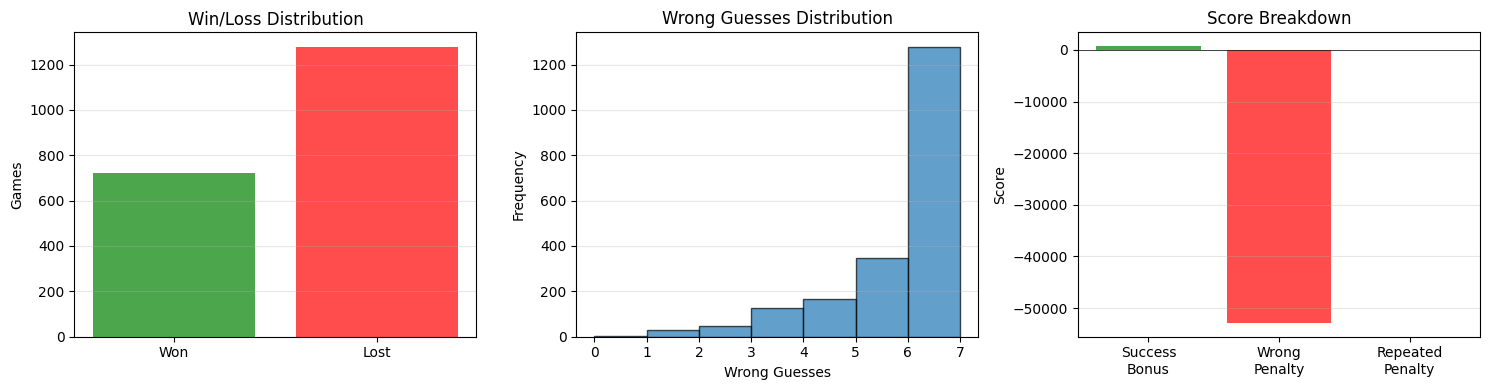

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].bar(['Won', 'Lost'], 
           [eval_results['games_won'], 
            eval_results['games_played'] - eval_results['games_won']],
           color=['green', 'red'], alpha=0.7)
axes[0].set_ylabel('Games')
axes[0].set_title('Win/Loss Distribution')
axes[0].grid(alpha=0.3, axis='y')

wrong_guesses_dist = [r['wrong_guesses'] for r in eval_results['word_results']]
axes[1].hist(wrong_guesses_dist, bins=range(0, 8), alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Wrong Guesses')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Wrong Guesses Distribution')
axes[1].grid(alpha=0.3, axis='y')

components = {
    'Success\nBonus': success_rate * 2000,
    'Wrong\nPenalty': -eval_results['total_wrong_guesses'] * 5,
    'Repeated\nPenalty': -eval_results['total_repeated_guesses'] * 2
}
colors = ['green', 'red', 'orange']
axes[2].bar(components.keys(), components.values(), color=colors, alpha=0.7)
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[2].set_ylabel('Score')
axes[2].set_title('Score Breakdown')
axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## OPTIONAL: Fine-tuning on Difficult Words

If you want to improve performance further, you can run focused training on words where the agent struggled.

In [ ]:
# OPTIONAL: Fine-tune on difficult words from test set (if you want even better performance)
# This is completely optional and should only be run if you want to push performance higher

def fine_tune_on_difficult_words(agent, eval_results, episodes=2000):
    """
    Fine-tune the agent on words it struggled with during evaluation.
    Uses the lost games to do focused practice.
    """
    # Get words that were lost
    difficult_words = [r['word'] for r in eval_results['word_results'] if not r['won']]
    
    if not difficult_words:
        print("No difficult words to train on - agent won all games!")
        return
    
    print(f"\nFine-tuning on {len(difficult_words)} difficult words for {episodes} episodes...")
    print("This helps the agent learn patterns it initially missed.\n")
    
    env = HangmanEnvironment(difficult_words, max_lives=6)
    
    # Lower learning rate for fine-tuning
    original_lr = agent.lr
    agent.lr = 0.1
    
    # Keep some exploration
    agent.epsilon = 0.0001
    
    stats = {'won': 0, 'total': 0}
    
    for episode in tqdm(range(episodes), desc="Fine-tuning"):
        state = env.reset()
        while not state['game_over']:
            action = agent.choose_action(state, env, training=True)
            if action is None:
                break
            next_state, reward, done = env.step(action)
            agent.update(state, action, reward, next_state, done)
            state = next_state
        
        stats['total'] += 1
        if env.won:
            stats['won'] += 1
        
        # Very slow epsilon decay during fine-tuning
        agent.epsilon = max(0.05, agent.epsilon * 0.999)
    
    # Restore original learning rate
    agent.lr = original_lr
    
    print(f"\nFine-tuning complete!")
    print(f"Win rate on difficult words during training: {stats['won']/stats['total']*100:.1f}%")
    print(f"Agent should now perform better on similar patterns.\n")

# Uncomment the following lines to run fine-tuning:
fine_tune_on_difficult_words(agent, eval_results, episodes=2000)
 
# # Re-evaluate after fine-tuning
print("\n" + "="*80)
print("RE-EVALUATING AFTER FINE-TUNING")
print("="*80)
eval_results_v2 = evaluate_agent(agent, test_words, max_lives=6, verbose=True)
# 
# # Recalculate final score
success_rate_v2 = eval_results_v2['games_won'] / eval_results_v2['games_played']
final_score_v2 = (success_rate_v2 * 2000) - (eval_results_v2['total_wrong_guesses'] * 5) - (eval_results_v2['total_repeated_guesses'] * 2)
# 
print(f"\nIMPROVEMENT:")
print(f"  Success Rate: {success_rate*100:.2f}% → {success_rate_v2*100:.2f}% ({(success_rate_v2-success_rate)*100:+.2f}%)")
print(f"  Final Score: {final_score:.2f} → {final_score_v2:.2f} ({final_score_v2-final_score:+.2f})")

print("Fine-tuning function defined.")


Fine-tuning on 1430 difficult words for 2000 episodes...
This helps the agent learn patterns it initially missed.



Fine-tuning: 100%|██████████| 2000/2000 [00:15<00:00, 130.42it/s]



Fine-tuning complete!
Win rate on difficult words during training: 6.0%
Agent should now perform better on similar patterns.


RE-EVALUATING AFTER FINE-TUNING

EVALUATING ON 2000 TEST WORDS



Evaluation Progress: 100%|██████████| 2000/2000 [00:15<00:00, 125.57it/s]


EVALUATION COMPLETE - DETAILED BREAKDOWN

Overall Performance:
  Games: 2000
  Wins: 675 (33.75%)
  Losses: 1325
  Avg Wrong Guesses: 5.31
  Total Repeated: 0

Performance by Word Length:
  Length  2:   0.0% win rate, 6.00 avg wrong (2 words)
  Length  3:  11.1% win rate, 5.89 avg wrong (9 words)
  Length  4:  10.8% win rate, 5.73 avg wrong (37 words)
  Length  5:  12.1% win rate, 5.71 avg wrong (91 words)
  Length  6:  18.8% win rate, 5.70 avg wrong (138 words)
  Length  7:  21.5% win rate, 5.62 avg wrong (205 words)
  Length  8:  27.2% win rate, 5.50 avg wrong (246 words)
  Length  9:  30.7% win rate, 5.41 avg wrong (274 words)
  Length 10:  34.8% win rate, 5.29 avg wrong (282 words)
  Length 11:  43.4% win rate, 5.21 avg wrong (226 words)
  Length 12:  45.1% win rate, 5.07 avg wrong (164 words)
  Length 13:  50.0% win rate, 4.88 avg wrong (128 words)
  Length 14:  44.2% win rate, 4.86 avg wrong (86 words)
  Length 15:  57.4% win rate, 4.53 avg wrong (47 words)
  Length 16:  57.6% w

## STEP 9: Save Results

In [36]:
# Save the trained agent and results
with open('hangman_agent.pkl', 'wb') as f:
    pickle.dump(agent, f)
print("✓ Model saved to: hangman_agent.pkl")

# Save evaluation results
results_dict = {
    'final_score': final_score,
    'success_rate': success_rate,
    'games_played': eval_results['games_played'],
    'games_won': eval_results['games_won'],
    'total_wrong_guesses': eval_results['total_wrong_guesses'],
    'total_repeated_guesses': eval_results['total_repeated_guesses'],
    'avg_wrong_guesses': eval_results['total_wrong_guesses']/eval_results['games_played'],
    'avg_repeated_guesses': eval_results['total_repeated_guesses']/eval_results['games_played']
}

with open('evaluation_results.json', 'w') as f:
    json.dump(results_dict, f, indent=2)
print("✓ Results saved to: evaluation_results.json")

# Save detailed word-by-word results
results_df = pd.DataFrame(eval_results['word_results'])
results_df.to_csv('detailed_results.csv', index=False)
print("✓ Detailed results saved to: detailed_results.csv")

# Display summary
print("\n" + "="*80)
print("TRAINING AND EVALUATION COMPLETE!")
print("="*80)
print(f"\nFinal Score: {final_score:.2f}")
print(f"Success Rate: {success_rate*100:.2f}%")
print(f"Average Wrong Guesses: {results_dict['avg_wrong_guesses']:.2f}")
print(f"Average Repeated Guesses: {results_dict['avg_repeated_guesses']:.2f}")
print("\nFiles created:")
print("  - hangman_agent.pkl (trained model)")
print("  - evaluation_results.json (summary metrics)")
print("  - detailed_results.csv (word-by-word results)")

AttributeError: Can't get local object 'HangmanHMM.__init__.<locals>.<lambda>'